# Predicting Newsletter Subscription Based on Session Behavior in Video Game Players

## DSCI 100 - Final Project Report

**Author:** Delia Zhang, Ryan Xie, Rachel McDonald, Oj Singh Dhillon   
**Date:** Fri, Apr 4th 

In [2]:
# Run this cell before continuing
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yards

## Introduction

### Background

Video games today are more than just entertainment. They’re complex digital spaces where people explore, create, and connect with others. One game that really captures this is Minecraft, which gives players the freedom to build, roam, and play however they want. That makes it a great environment for studying how people interact in virtual worlds. At the University of British Columbia, a research team in the Department of Computer Science led by Dr. Frank Wood is using Minecraft to explore these questions. The group, known as PLAI (Pacific Laboratory for Artificial Intelligence), has set up a research server where every action a player takes is recorded. This creates a dataset full of patterns and behaviors. The big question we’re tackling in this project is: what can we learn from this data about the kinds of players who choose to subscribe to a game-related newsletter?

Subscribing to a newsletter might seem like a small thing, but it actually tells us a lot. It’s a sign that the player is interested in what’s happening beyond just the gameplay. Maybe they want updates, research findings, or even to stay connected to the community. For the researchers running the server, knowing what types of players are more likely to subscribe helps them plan ahead. They can focus their outreach on players who are more likely to stay involved or support the project over time.

In this project, we’re looking at what in-game actions or player traits predict whether someone subscribes to the newsletter. Specifically, we’re focusing on the relationship between session length and session frequency, and whether those factors can help predict if a player has subscribed. Newsletters are often used as a marketing and engagement tool, giving players updates about new features, events, or research findings. Knowing which players are more likely to sign up can help the research team and game developers tailor their outreach and strengthen community involvement. If certain patterns of gameplay are linked to higher interest in newsletters, those insights could be used to improve communication strategies and even shape how future research participants are recruited.

### Research Question

**Can session length and frequency predict whether a player subscribes to the newsletter?**

To explore whether session length and frequency can predict newsletter subscription, we are using gameplay data collected from the Minecraft research server. This dataset includes detailed information about each player's activity, such as how often they log in (session frequency) and how long they play during each session (session length). These two variables will serve as predictors, and the target variable is whether or not the player subscribed to the game-related newsletter. To analyze this relationship, we are using a K-Nearest Neighbors (KNN) classification model, which allows us to identify patterns by comparing each player to others with similar behavior. By training the model on the existing data, we aim to see whether certain play habits are linked to a higher chance of subscribing. If a clear pattern exists, the results could help the research team identify and engage with players who are most likely to stay connected to the project.

In [3]:
# Load datasets
players <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/players.csv")
sessions <- read.csv("https://raw.githubusercontent.com/ryanraen/dsci-100-term-project/refs/heads/main/data/sessions.csv")

# View first 6 rows of datasets
head(players)
head(sessions)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### Dataset Description

The data is composed of two primary CSV files:
- **players.csv**: Contains demographic and game engagement data for 196 individuals. Variables include:
  - `experience`: Player's self-rated experience level (e.g., Pro, Veteran, Amateur)
  - `subscribe`: Boolean indicator of newsletter subscription
  - `hashedEmail`: An anonymized player identifier
  - `played_hours`: Total hours the player has spent in-game
  - `name`: Player’s given name
  - `gender`: Gender identity
  - `Age`: Age in years

- **sessions.csv**: Contains 1,535 individual game session logs, with the following variables:
  - `hashedEmail`: The same anonymized player identifier as in `players.csv`
  - `start_time`, `end_time`: Session timestamps (character format)
  - `original_start_time`, `original_end_time`: Session timestamps in UNIX format

## Variables & Data Types

### Players data types
It includes 7 variables:
- `experience` – Character type
- `subscribe` – Logical type (TRUE/FALSE)
- `hashedEmail` – Character type
- `played_hours` – Numeric type
- `name` – Character type
- `gender` – Character type
- `Age` – Integer type

### Sessions data types
It includes 5 variables:
- `hashedEmail` – Character type
- `start_time` – Character type
- `end_time` – Character type
- `original_start_time` – Numeric type
- `original_end_time` – Numeric type

In [4]:
# Get data types for each dataset in a table format
players_types <- data.frame(
  variable = colnames(players),
  data_type = map_chr(players, class))

sessions_types <- data.frame(
  variable = colnames(sessions),
  data_type = map_chr(sessions, class))

players_types
sessions_types

,variable,data_type
,<chr>,<chr>
experience,experience,character
subscribe,subscribe,logical
hashedEmail,hashedEmail,character
played_hours,played_hours,numeric
name,name,character
gender,gender,character
Age,Age,integer


,variable,data_type
,<chr>,<chr>
hashedEmail,hashedEmail,character
start_time,start_time,character
end_time,end_time,character
original_start_time,original_start_time,numeric
original_end_time,original_end_time,numeric


## Variable Descriptions

### Players variables
This dataset contains general information about each player:
- `experience` – Describes how experienced a player is
- `subscribe` – Indicates whether the player subscribed to the newsletter (TRUE or FALSE)
- `hashedEmail` – A hashed version of the player's email address, used as a unique identifier
- `played_hours` – The total amount of time the player has spent in-game, measured in hours
- `name` – The player’s in-game name
- `gender` – The player’s gender
- `Age` – The age of the player

### Sessions variables
This dataset records specific gameplay sessions for each player:
- `hashedEmail` – Matches players across datasets using their hashed email address
- `start_time` – The session’s start time in character format
- `end_time` – The session’s end time in character format
- `original_start_time` – The session’s start time as a UNIX timestamp
- `original_end_time` – The session’s end time as a UNIX timestamp

In [5]:
# Creating a variable description table
players_variables <- data.frame(
  Variable = colnames(players),
  Description = c(
    "How experienced a player is",
    "Newsletter subscription status",
    "Hashed email address",
    "Total playtime (in hours)",
    "Player name",
    "Player gender",
    "Player age"))

sessions_variables <- data.frame(
  Variable = colnames(sessions),
  Description = c(
    "Hashed email address",
    "Session start time",
    "Session end time",
    "Session start time from UNIX",
    "Session end time from UNIX"))

players_variables
sessions_variables

Variable,Description
<chr>,<chr>
experience,How experienced a player is
subscribe,Newsletter subscription status
hashedEmail,Hashed email address
played_hours,Total playtime (in hours)
name,Player name
gender,Player gender
Age,Player age


Variable,Description
<chr>,<chr>
hashedEmail,Hashed email address
start_time,Session start time
end_time,Session end time
original_start_time,Session start time from UNIX
original_end_time,Session end time from UNIX


## Summary Statistics & Observations

The `players` dataset provides a summary of the players dataset, focusing on two numeric variables: age and total playtime (measured in hours). The youngest player in the dataset is 8 years old, and the oldest is 50. The median age is 19, which means that half of the players are younger than 19 and half are older. The standard deviation for age is about 6.17 years, indicating that most players are within about 6 years of the average age. For total playtime, the minimum number of hours played is 0, while the maximum is 223.1 hours. The median playtime is very low—just 0.1 hours—suggesting that many players only played briefly. The standard deviation is quite high at 28.36 hours, which means there is a lot of variation in how much time different players spent in the game.

The `sessions` dataset summarizes the sessions dataset, which includes timestamps for when players started and ended their sessions. These times are recorded as UNIX timestamps (large numbers representing the number of milliseconds since January 1, 1970). The earliest session start time in the dataset is around 1.7124e+12, and the latest is 1.7273e+12. The median start time is 1.7192e+12. Similarly, the earliest and median end times are close in value. The timestamps range over several months, and the standard deviation of start and end times is about 3.5 billion in UNIX units, suggesting a broad distribution of activity across time.

In [6]:
# Number of observations and variables  
dataset_summary <- data.frame(
  dataset = c("Players", "Sessions"),
  observations = c(nrow(players), nrow(sessions)),
  variables = c(ncol(players), ncol(sessions)))

dataset_summary

dataset,observations,variables
<chr>,<int>,<int>
Players,196,7
Sessions,1535,5


In [7]:
# Players summary
players_summary <- players |>
  select(Age, played_hours) |>
  summarise(across(everything(), list(
    min = min,
    median = median,
    max = max,
    sd = sd
  ), na.rm = TRUE))

# Sessions summary
sessions_summary <- sessions |>
  select(original_start_time, original_end_time) |>
  summarise(across(everything(), list(
    min = min,
    median = median,
    max = max,
    sd = sd
  ), na.rm = TRUE))

players_summary
sessions_summary

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(...)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


Age_min,Age_median,Age_max,Age_sd,played_hours_min,played_hours_median,played_hours_max,played_hours_sd
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,19,50,6.174667,0,0.1,223.1,28.35734


original_start_time_min,original_start_time_median,original_start_time_max,original_start_time_sd,original_end_time_min,original_end_time_median,original_end_time_max,original_end_time_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.7124e+12,1.7192e+12,1.72733e+12,3557491589,1.7124e+12,1.71918e+12,1.72734e+12,3552813134


## Data Issues and Considerations

Before modeling, several data quality issues were considered:
- **Missing values**: Both datasets contained a small number of NA values (2 each), which were removed.
- **Outliers**: Some players had extremely long or short playtimes or session lengths.
- **Encoding**: Categorical variables (e.g., experience, gender) were not used in this model but could be considered in future work.
- **Duplicates**: No duplicate rows were found.
- **Session timestamps**: Required conversion to extract session durations in minutes.
- **Class imbalance**: The majority of players *are* subscribed to a newsletter.

By combining both datasets using the `hashedEmail` identifier, we calculated two key behavioral features for each player:
- **Average session length**: Mean time spent per session
- **Total session count**: Number of distinct sessions played

These variables form the basis of our predictive analysis.

In [8]:
# Checking for missing values
missing_values <- data.frame(
  dataset = c("Players", "Sessions"),
  total_missing_values = c(sum(is.na(players)), sum(is.na(sessions))))

# Checking for duplicate rows
duplicate_rows <- data.frame(
  dataset = c("Players", "Sessions"),
  total_duplicates = c(sum(duplicated(players)), sum(duplicated(sessions))))

missing_values
duplicate_rows

dataset,total_missing_values
<chr>,<int>
Players,2
Sessions,2


dataset,total_duplicates
<chr>,<int>
Players,0
Sessions,0


In [9]:
# Drop missing values
players_clean <- players |> drop_na()
sessions_clean <- sessions |> drop_na()

## Methods & Results

### Cleaning & wrangling data

We’re doing this next step to turn detailed session data into something that’s actually useful for modeling. Right now, each row in the `sessions_clean` dataset represents a single time someone played the game. That’s helpful for tracking individual sessions, but not very useful when we want to look at overall player behavior, especially if we’re trying to predict whether someone subscribed to the newsletter.

So first, we calculate how long each session lasted by subtracting the start time from the end time, and converting that into minutes. This gives us a new column called `duration`, which tells us how long a player played during each session.

Next, we group the data by player, using the `hashedEmail` column to identify each one. For each player, we calculate their average session length and the total number of sessions they played. These two numbers give us a simple and meaningful way to describe how engaged each player is with the game.

The result is a summary table where each row represents one player, along with their average session time and how often they played. This is important because it gives us clean, organized data that we can use to build a predictive model. From here, we can combine it with other player information, like age or whether they subscribed, and start analyzing whether play habits are related to newsletter subscription.

In [10]:
# Create session duration in minutes
sessions_clean <- sessions_clean |>
  mutate(duration = as.numeric(difftime(
    as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"),
    as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    units = "mins")))

# Summarize per player
session_summary <- sessions_clean |>
  group_by(hashedEmail) |>
  summarise(
    avg_session_length = mean(duration, na.rm = TRUE),
    num_sessions = n(),
    .groups = "drop")

head(session_summary)

hashedEmail,avg_session_length,num_sessions
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000,1


Right now, we have two separate datasets: one (`players_clean`) contains personal information like age, gender, and whether they subscribed, and the other (`session_summary`) has gameplay behavior like average session length and number of sessions. By using `inner_join()` on the `hashedEmail` column, we’re combining both datasets so that each row represents a single player and includes both types of information.

We use `inner_join()` specifically because we only want to include players who have both player info and session data. If someone never played the game, we can’t calculate session stats for them, so they wouldn’t be useful for this particular analysis.

We use `drop_na()` to remove any rows that still have missing values. This helps make sure the data we feed into our model is clean and complete, which improves accuracy and avoids errors during training.

Finally, we convert the subscribe variable into a factor because it is a categorical outcome. This tells R to treat it as a label for classification, which is necessary when using models like K-Nearest Neighbors that predict class membership instead of numerical values.

In [11]:
merged_data <- players_clean |>
  inner_join(session_summary, by = "hashedEmail") |> # Merge session behavior with player info
  drop_na() |>                                       # Remove any rows with missing values
  mutate(subscribe = as.factor(subscribe))           # Convert subscription to factor for classification

head(merged_data)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length,num_sessions
,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50.00000,1
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9.00000,1
6,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5.00000,1


### Visualizing data

We created these graphs to explore how players behave in the game and to see whether that behavior might be related to newsletter subscription. Our research question asks whether session length and session frequency can help predict if a player subscribes to the newsletter. Before building a model, it's important to look at the data visually. These graphs help us understand what kinds of patterns exist in player behavior.

The first histogram shows the distribution of average session length. This lets us see whether most players are playing for short amounts of time or staying in the game longer. It also shows how much variation there is across players. For example, if a few players have very long sessions while most play briefly, that could influence how useful this feature is for prediction.

The second histogram looks at how often players log in. This shows us how engaged players are, based on how many sessions they have. If subscribers tend to play more often than non-subscribers, then the number of sessions might be a good predictor in our model.

The scatterplot combines both of these features (average session length and number of sessions) and adds subscription status by using color. This helps us compare player behavior across both variables at the same time. If subscribers and non-subscribers appear in different areas of the plot, it suggests that session behavior might really be linked to whether someone subscribes.

 avg_session_length  num_sessions     played_hours          Age       
 Min.   :  5.00     Min.   :  1.00   Min.   :  0.000   Min.   : 8.00  
 1st Qu.: 10.00     1st Qu.:  1.00   1st Qu.:  0.100   1st Qu.:17.00  
 Median : 19.00     Median :  1.00   Median :  0.400   Median :19.00  
 Mean   : 32.85     Mean   : 12.45   Mean   :  9.313   Mean   :20.61  
 3rd Qu.: 46.00     3rd Qu.:  2.00   3rd Qu.:  1.500   3rd Qu.:22.50  
 Max.   :150.34     Max.   :310.00   Max.   :223.100   Max.   :50.00  

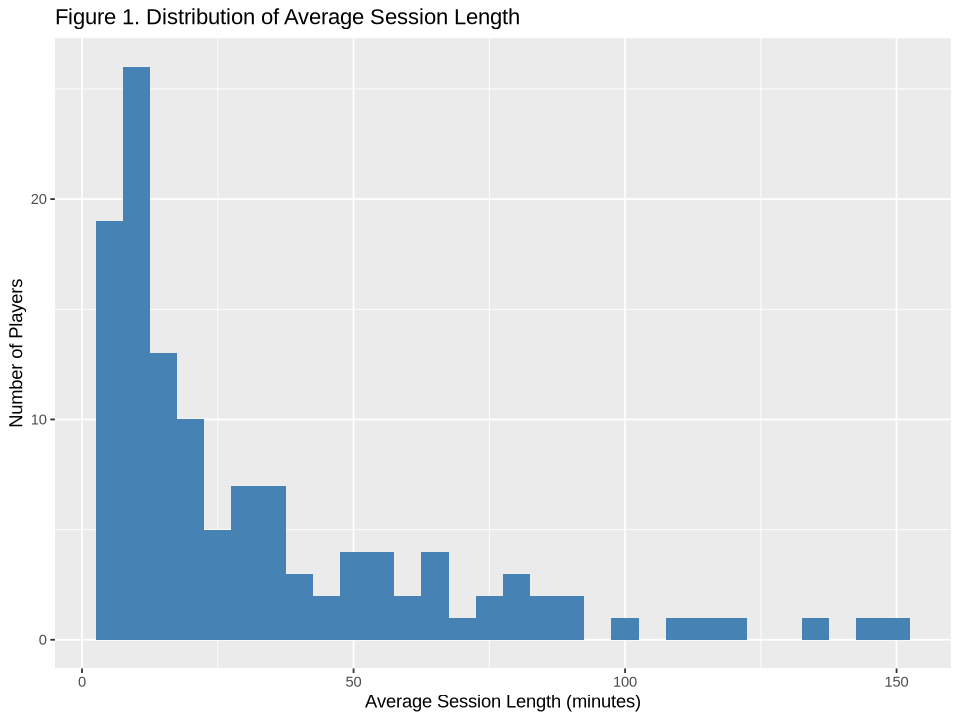

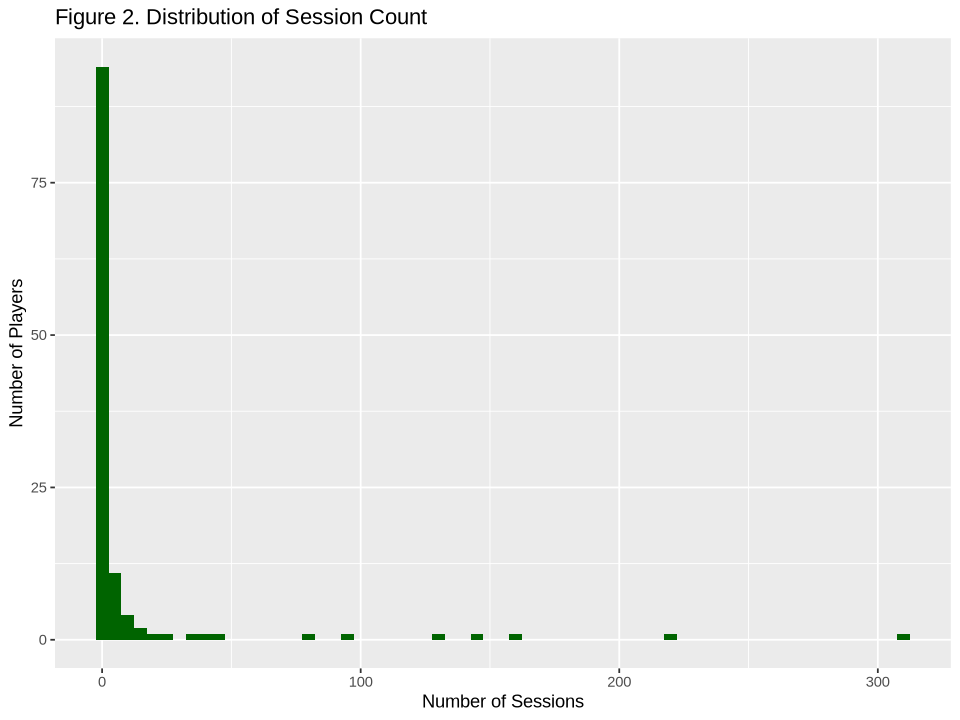

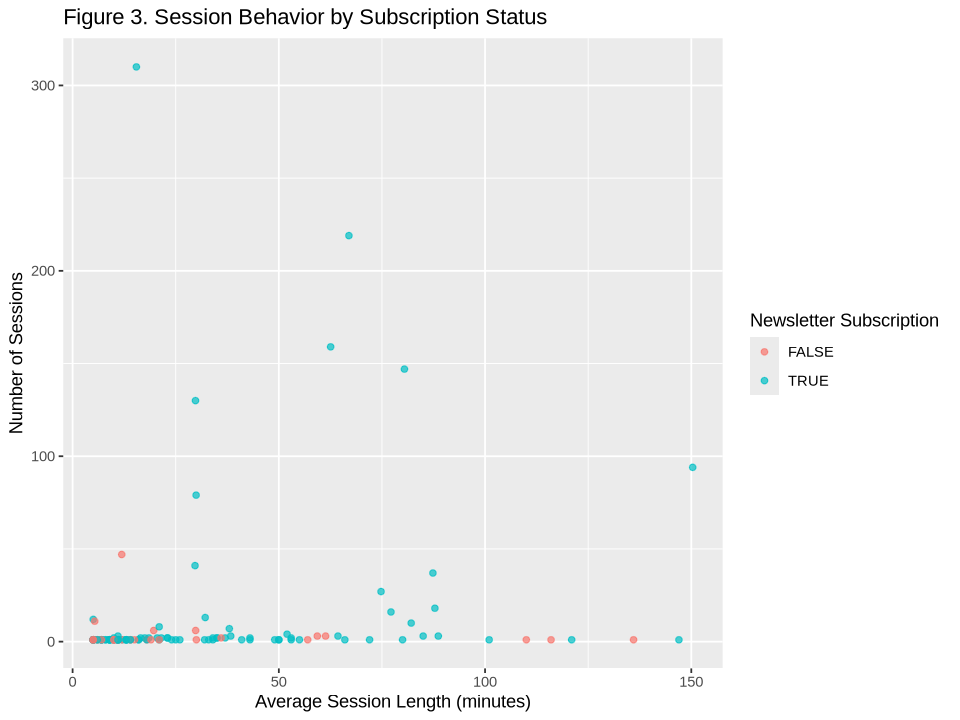

In [12]:
# Set plot size
options(repr.plot.width = 8, repr.plot.height = 6)

# Summary statistics
summary(merged_data[c("avg_session_length", "num_sessions", "played_hours", "Age")])

# Histogram of average session length
ggplot(merged_data, aes(x = avg_session_length)) +
  geom_histogram(binwidth = 5, fill = "steelblue") +
  labs(
    title = "Figure 1. Distribution of Average Session Length",
    x = "Average Session Length (minutes)",
    y = "Number of Players",
    fill = "Session Length")

# Histogram of number of sessions
ggplot(merged_data, aes(x = num_sessions)) +
  geom_histogram(binwidth = 5, fill = "darkgreen") +
  labs(
    title = "Figure 2. Distribution of Session Count",
    x = "Number of Sessions",
    y = "Number of Players",
    fill = "Session Count")

# Scatterplot: avg session length vs. number of sessions by subscription
ggplot(merged_data, aes(x = avg_session_length, y = num_sessions, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Figure 3. Session Behavior by Subscription Status",
    x = "Average Session Length (minutes)",
    y = "Number of Sessions",
    color = "Subscribed"
  ) +
  theme(legend.position = "right") +
  guides(color = guide_legend(title = "Newsletter Subscription"))

### Analyzing graphs

#### Figure 1 - Distribution of average session length
This histogram shows the distribution of average session length among players. Most players have short average session lengths, with the highest number falling between 5 and 15 minutes. As session length increases, the number of players decreases steadily. Only a small number of players have average session lengths above 60 minutes. This suggests that while a few players are highly engaged and spend a long time in each session, the majority play in shorter bursts. The data is clearly right-skewed, with a long tail extending toward longer session durations.

#### Figure 2 - Distribution of session count
This histogram shows the distribution of how many sessions each player has. The vast majority of players have only a small number of sessions, with the highest bar around just 1 to 5 sessions. A much smaller number of players have higher session counts, and a few outliers have played well over 100 or even 300 sessions. This distribution is heavily right-skewed, meaning most players are relatively inactive, while a small group of highly active players skews the data. This pattern suggests that session count may be a strong indicator of engagement, and could help in identifying which players are more likely to subscribe to the newsletter.

#### Figure 3 - Session behavior by subscription status
This scatterplot shows the relationship between average session length and number of sessions, with players colored by their newsletter subscription status. Each point represents a player. From the plot, we can see that most players cluster in the bottom left corner, meaning they have both short sessions and few total sessions. However, players who subscribed to the newsletter (in blue) are more spread out and appear more often in areas with higher session counts and longer average session lengths. In contrast, players who did not subscribe (in red) tend to stay near the lower end of both axes. This suggests that players who are more active may be more likely to subscribe to the newsletter. It gives early visual support for the idea that session behavior could be a useful predictor of subscription status.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6496732,5,0.05558357,Preprocessor1_Model02
1,accuracy,binary,0.6489379,5,0.03723725,Preprocessor1_Model01
3,accuracy,binary,0.5898693,5,0.03066856,Preprocessor1_Model03
5,accuracy,binary,0.5683824,5,0.04149603,Preprocessor1_Model05
4,accuracy,binary,0.5662582,5,0.04267499,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,accuracy,binary,0.4254902,5,0.05010951,Preprocessor1_Model46
47,accuracy,binary,0.4178105,5,0.07213657,Preprocessor1_Model47
48,accuracy,binary,0.4178105,5,0.07213657,Preprocessor1_Model48


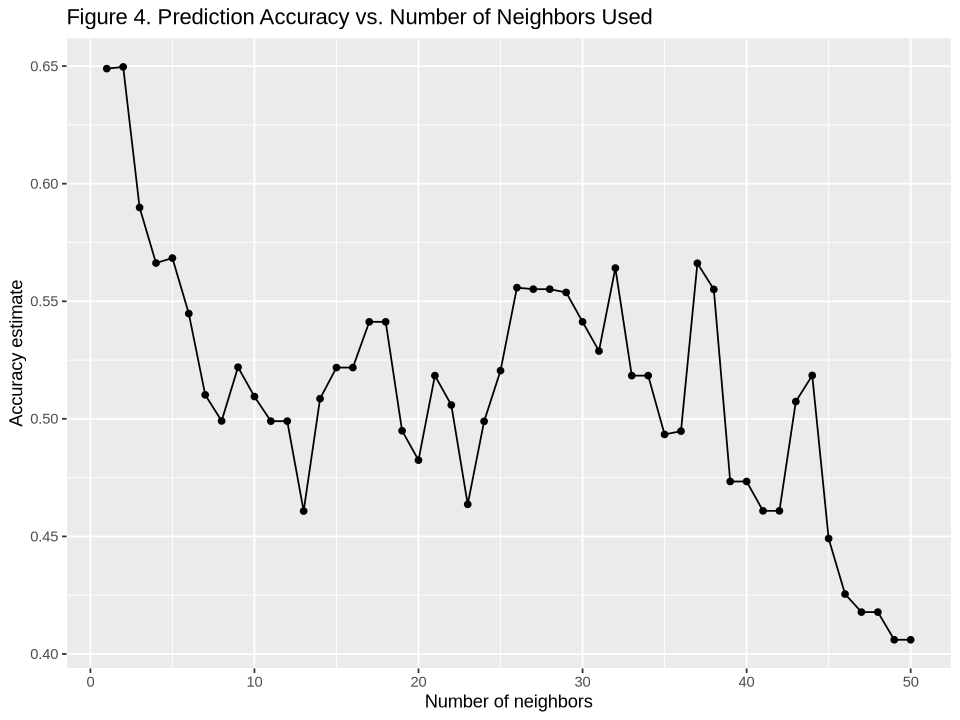

In [24]:
# Create recipe
knn_recipe <- recipe(subscribe ~ avg_session_length + num_sessions, data = merged_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE)

# Create training/testing split
set.seed(123)
split <- initial_split(merged_data, prop = 0.7, strata = subscribe)
train_data <- training(split)
test_data <- testing(split)

# Define K-NN model
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Workflow
knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

# Test K values 1-50
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Apply 5 vfold cross validation
data_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

k_metrics <- knn_workflow |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Isolate accuracies for each K value
accuracies <- k_metrics |>
  filter(.metric == "accuracy")

# Visualize prediction accuracy and number of neighbors
best_k_vis <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 4. Prediction Accuracy vs. Number of Neighbors Used", x = "Number of neighbors", y = "Accuracy estimate")

options(repr.plot.width = 10, repr.plot.width = 8)
best_k_vis

arrange(accuracies, -mean)

From the plot above, we can see that for:
- Small K values (1-10), there is a sharp dip in accuracy past K = 1 and there are fluctuations, suggesting potential overfitting.
- Mid-range K values (11-25), accuracies oscillate and fluctuate significantly, again implying overfitting.
- Higher K values (26-35), around K = 30 to K = 35, the accuracy is relatively stable, though still not very high.
- Large K values (36-50), there is a major drop in accuracy, potentially indicating underfitting as too many neighbors excessively generalizes the model.

Since our model uses supervised learning, we will simply choose the K value that yields the greatest mean validation accuracy. That is, choose **K = 2**.

It is important to note that even with our optimal K value, the mean accuracy is still only ~ 65%, which is quite ineffectively for predicting the class of ```subscribe```. 

In [22]:
# Define new K-NN model with K = 2
best_knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit new model
knn_fit <- workflow() |>
  add_model(best_knn_model) |>
  add_recipe(knn_recipe) |>
  fit(data = train_data)

# Predict and evaluate on test data
preds <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

# Metrics
metrics(preds, truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Confusion matrix
conf_mat(preds, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6052632


          Truth
Prediction FALSE TRUE
     FALSE     6   11
     TRUE      4   17

## Discussion & Conclusion

### Summary

As per the accuracy metric, K = 2 has an accuracy of 60.53% on the testing set, however, the accuracy is too low and not optimal for a K-NN model. This suggests that the predictors session length and frequency do not effectively predict whether a player subscribes to the newsletter. 

The choice of K = 2 neighbors is generally quite low for a K-NN classification model. The reliance on only the two nearest neighbors makes the classifier very sensitive to noise in the training data, leading to high variance. In fact, based on the training accuracy for K = 2 shown in Figure 4, we find that our testing accuracy of 60.53% is considerably lower than our training accuracy of 64.97%. This pattern suggests that the model may be overfitting the training data, since it performs well on the training set but fails to generalize and perform effectively on foreign data. Although choosing a higher K value could have smoothed the decision boundary and reduced overfitting, it is unwarranted since greater K values yielded significantly lower cross-validation accuracies on the training set.

Moreover, based on the confusion matrix, a 80.95% precision and 60.71% recall can be concluded. The notable disparity between precision and recall indicates that the model is rather conservative in predicting newsletter subscriptions. Recollect that precision quantifies how many of the positive predictions the classifier made were actually positive, while recall measures how many of the positive observations in the test set were identified as positive. That is, our classifier predicts fewer false positives but misses more true positives. When it predicts that a player is a subscriber, it tends to be correct (high precision), however, it fails to identify many actual subscribers (low recall). 

### Expectations

Based on Figure 3, there doesn’t seem to be a clear correlation between the predictors and response variable. Thus, we didn’t expect the model to be incredibly accurate at predicting subscription status, since the predictors are weakly correlated with the response variable. 

### Impacts

The findings from our model can potentially be helpful for researchers when choosing which players to target in recruiting. Subscription to a video game’s newsletter indicates the player is interested in the game, and would likely continue to play and support the research initiative. Since our model demonstrates that session length and frequency do not effectively predict whether a player subscribes to a newsletter, researchers should focus less on session length and frequency when targeting potential players. However, if researchers did want to consider these variables in their recruitment efforts, then it would be more beneficial to focus on the session length variable versus frequency of sessions. As per Figure 3, the number of non-subscribed players decreases (except for a few outliers) as session length increases, indicating that the longer the session the more likely the player is to be subscribed. Although this a weak correlation, the relation is still evident, and could be something that researchers could consider when recruiting. Overall, session length and frequency are weak predictors of subscription status, and it would be most beneficial for researchers to consider other variables in their recruitment efforts. 

### Future Questions

- How effective are other variables at predicting whether a player subscribes?
- What variables, in combination, are most effective in this predictive process? 
- With a larger dataset, would the predictors session length and session frequency be more accurate?
- Could alternate predictive modeling techniques (i.e. decision trees) be more effective in this process?
- Are these findings applicable to all video games or just Minecraft?
